In [2]:
import json
import numpy as np
import os
import locale
import pandas as pd

# Curve fitting
import tensorflow as tf

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_ml import create_tf_model
from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)
from stock_modules.stock_transform import (histories_to_array,
                                           create_batch_xy)
from stock_modules.stock_plot import plot_strategy_based_on_predictions

from invest_strategies import (calculate_optimal_invest_strategy, test_invest_strategy, calculate_profit_on_invest_strategy)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

In [3]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23_timedelta.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./model.h5"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['Time Delta', 'REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE',
       'OLVAS.HE', 'HUH1V.HE', 'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE',
       'ALBBV.HE', 'VALMT.HE', 'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 15)
Dataframe head: 
                      Time Delta   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE  \
date                                                                          
2021-10-12 07:00:00           1  55.950001  41.820000  35.689999  60.220001   
2021-10-12 08:00:00           1  55.799999  41.720001  35.630001  60.419998   

                      OLVAS.HE   HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE  \
date                                                                        
2021-10-12 07:00:00  53.099998  38.529999     

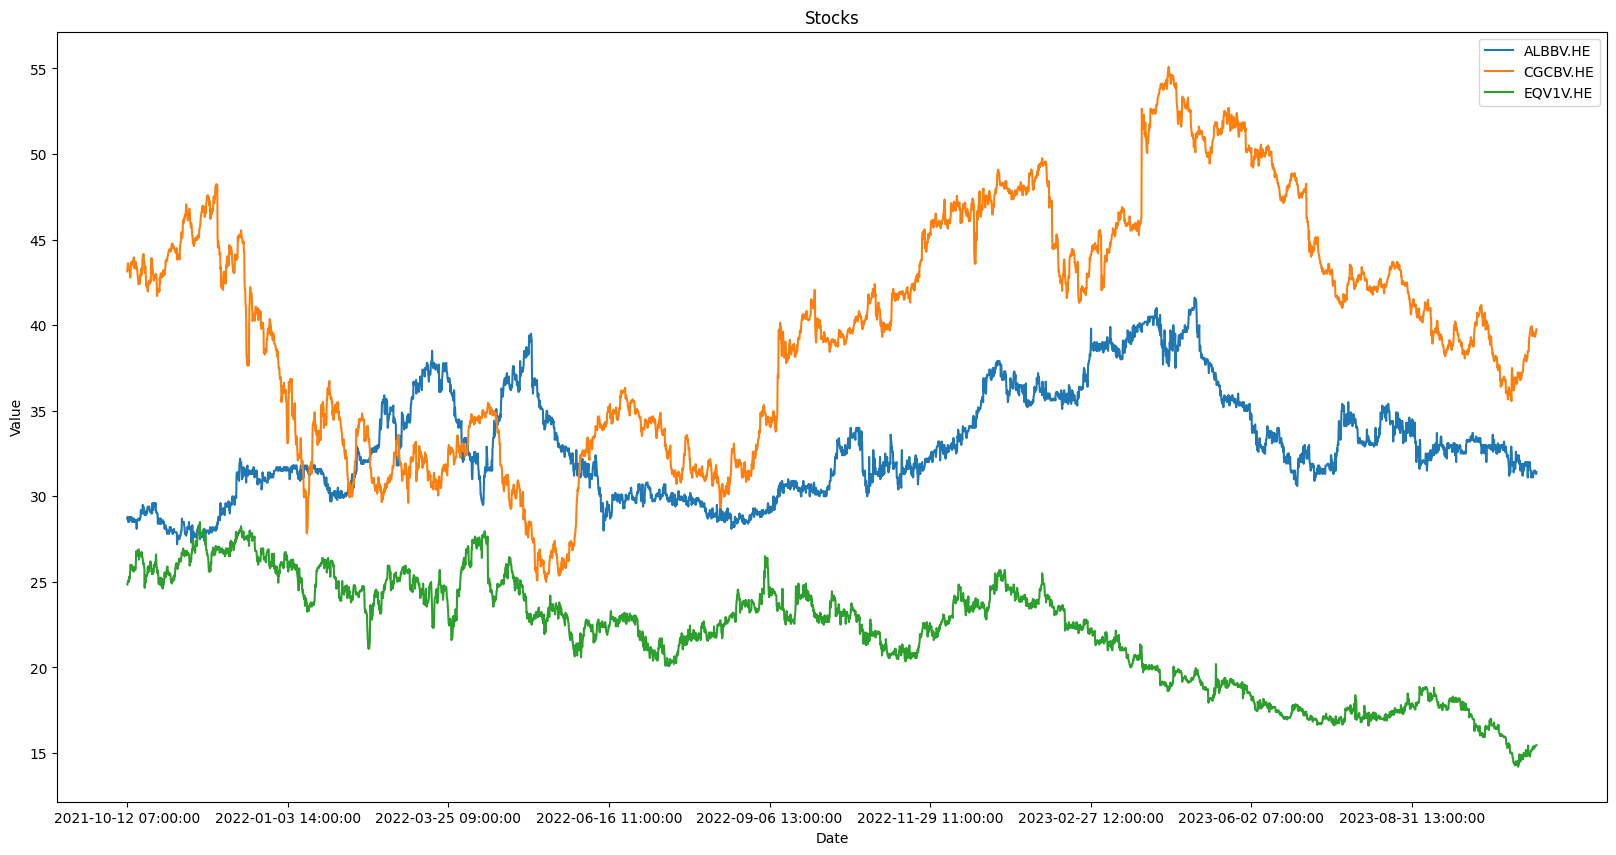

In [4]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [5]:
# Scale data, and define an inversion function
TEST_FRAC = 0.2
scaler = MinMaxScaler()
test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))
# Remove Time Delta

scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
transformed_np_arr = transformed_df.to_numpy()

def inverse_transform(df):
    if isinstance(df, pd.DataFrame):
        return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
    elif isinstance(df, np.ndarray):
        return scaler.inverse_transform(df)

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      Time Delta  REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  \
date                                                                      
2021-10-12 07:00:00         0.0  0.910555  0.511154  0.074003  0.857405   
2021-10-12 08:00:00         0.0  0.905188  0.506305  0.071120  0.864756   

                     OLVAS.HE  HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  \
date                                                                    
2021-10-12 07:00:00  0.992424  0.896318  0.387665  0.197619  0.602658   
2021-10-12 08:00:00  1.000000  0.898573  0.387665  0.197619  0.614618   

                     VAIAS.HE  ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                                   
2021-10-12 07:00:00  0.512887  0.104167  0.890633  0.656955  0.624266  
2021-10-12 08:00:00  0.502577  0.111111  0.898213  0.666353  0.626223  
Transformed df shape:  (4389, 15)


In [6]:
MHOURS = 24

# Batch X data into sequences of length MHOURS (from T to T+n), and Y data
# into sequences of length 1 (T+n+1)
X, Y = create_batch_xy(MHOURS, transformed_np_arr, overlap=True)

X_og = X.copy()
Y_og = Y.copy()

test_sz = int(X.shape[0] * TEST_FRAC)

# Split the data into train and test sets
X_train = X[:-test_sz,:,:]
Y_train = Y[:-test_sz,:]
X_test = X[-test_sz:,:,:]
Y_test = Y[-test_sz:,:]


            Batched 'histories_arr' ((4389, 15)) to 'X'
            ((4365, 24, 15)) and 'Y' ((4365, 15))
            


In [8]:
MODEL_PATH = "./model.h5"
RENEW_MODEL = True
PATIENCE = 10
EPOCHS = 100
BATCH_SIZE = 64

class SkipTDLoss(tf.keras.losses.Loss):
    """Huber loss function, that does not account for loss on the first column (Time Delta)
    """
    def __init__(self, delta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.huber_fn = tf.keras.losses.Huber(delta=delta, reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        # Skip first column
        return self.huber_fn(y_true[:, 1:], y_pred[:, 1:])


# Fit model by showing it the data from the last MHOURS hours, and
# predicting the next hour
if os.path.exists(MODEL_PATH) and not RENEW_MODEL:
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"SkipTDLoss": SkipTDLoss})
else:
    model = create_tf_model(MHOURS, X.shape[2])
    if HAS_TIMEDELTA:
        model.compile(loss=SkipTDLoss(), optimizer="adam")
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    model.fit(X_train, Y_train,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(X_test, Y_test), verbose=1,
            callbacks=[early_stop], shuffle=True)
    model.save(MODEL_PATH)
print("Model summary: \n", model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 15)]     0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 24, 128)     40960       ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 24, 32)      18560       ['bidirectional_4[0][0]']        
 )                                                                                                
                                                                                            

In [9]:
# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
prediction_trading_mask = test_invest_strategy(np_arr_test, transformed_np_arr_test, MHOURS, model, inversion = lambda x : inverse_transform(x))
profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal strategy matrix shape: (877, 14)
Profit by optimal strategy on test data: 152.34999465942383
transformed_np_arr_test data shape:  (877, 15)

            Batched 'histories_arr' ((877, 15)) to 'X'
            ((853, 24, 15)) and 'Y' ((853, 15))
            

            Batched 'histories_arr' ((877, 14)) to 'X'
            ((853, 24, 14)) and 'Y' ((853, 14))
            
27/27 [==============================] - 1s 8ms/step
Prediction strategy matrix shape: (877, 14)
Profit by predicting the next hour using the model: -27.8899984359741



            Batched 'histories_arr' ((877, 14)) to 'X'
            ((853, 24, 14)) and 'Y' ((853, 14))
            

            Profit on optimal strategy:
            152.34999465942383
            

            Batched 'histories_arr' ((877, 15)) to 'X'
            ((853, 24, 15)) and 'Y' ((853, 15))
            

            Batched 'histories_arr' ((877, 14)) to 'X'
            ((853, 24, 14)) and 'Y' ((853, 14))
            
27/27 [==============================] - 0s 10ms/step
Profit on invest strategy: 123.34999752044678


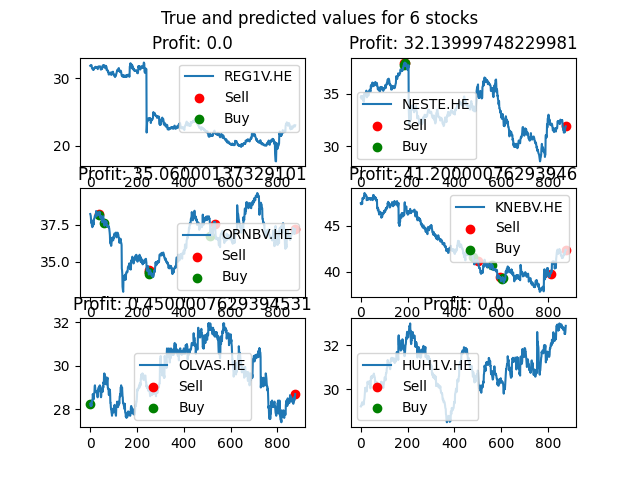

28/28 [==============================] - 0s 11ms/step

            Batched 'histories_arr' ((4389, 15)) to 'X'
            ((4365, 24, 15)) and 'Y' ((4365, 15))
            


In [ ]:
%matplotlib widget
plot_strategy_based_on_predictions(np_arr_test, transformed_np_arr_test, model, MHOURS, inversion = lambda x : inverse_transform(x), show = True,ind_conversion=IND_CONVERSION)

# Predict the next hours for the test data
Y_pred = model.predict(X_test)

# Test on the last TEST_SIZE of the data
test_begin_idx = int(transformed_np_arr_test.shape[0]*(1-TEST_FRAC))
X_overlap, Y_overlap = create_batch_xy(
    MHOURS, transformed_np_arr, overlap=True
)

137/137 [==============================] - 2s 11ms/step


Text(0.5, 1.0, 'True and predicted values for 5 stocks')

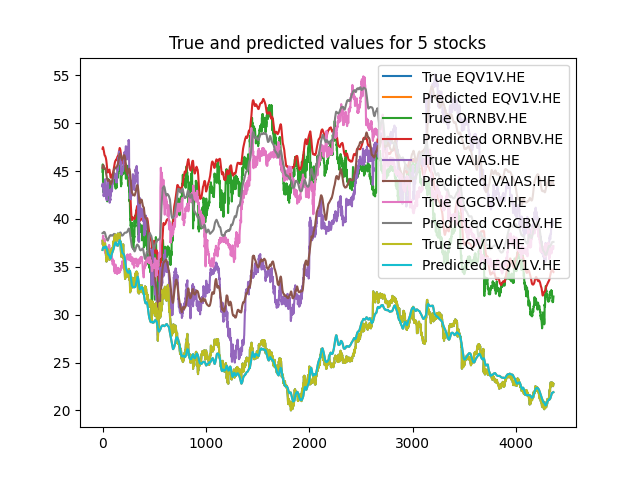

In [ ]:
# predict every hour
Y_pred_overlap = model.predict(X_overlap)

# Invert scaling of predictions
Y_pred_overlap = inverse_transform(Y_pred_overlap)
Y_overlap = inverse_transform(Y_overlap)

# Plot true values and predicted values for 5 selected stocks
stock_idxs = np.random.randint(0,X.shape[2],5)
fig, ax = plt.subplots()
for stock_idx in stock_idxs:
        ax.plot(Y_overlap[:,stock_idx],
                label=f"True {IND_CONVERSION[stock_idx]}")
        ax.plot(Y_pred_overlap[:,stock_idx],
                label=f"Predicted {IND_CONVERSION[stock_idx]}")
ax.legend()
ax.set_title("True and predicted values for 5 stocks")
# Save

X_start shape: (24, 15)
Y_preds_recurse shape: (1, 15)
Y_true_recurse shape: (50, 15)
Y_preds_recurse shape: (50, 15)
Mean absolute error of hourly predictions: [0.14329686 0.20462575 0.084978   0.15502118 0.09725725 0.10448766
 0.06214195 0.08135775 0.06459819 0.09492922 0.12844856 0.09383194
 0.02497612 0.06333736 0.08240493]
Mean absolute error of recursive predictions:
        [14.29827001  6.29971894  4.86675142  6.36897819  2.98885444  2.35948857
  2.00608775  4.90750489  4.65239363  6.12021007  5.21270395  1.08898228
  0.73520832  2.14634046  0.86191564]
Average hourly change: [0.05806265 0.00460275 0.00683846 0.00567333 0.00496563 0.00453286
 0.00699274 0.00610526 0.00610529 0.00490414 0.00813688 0.01522682
 0.00446112 0.00986627 0.00748442]


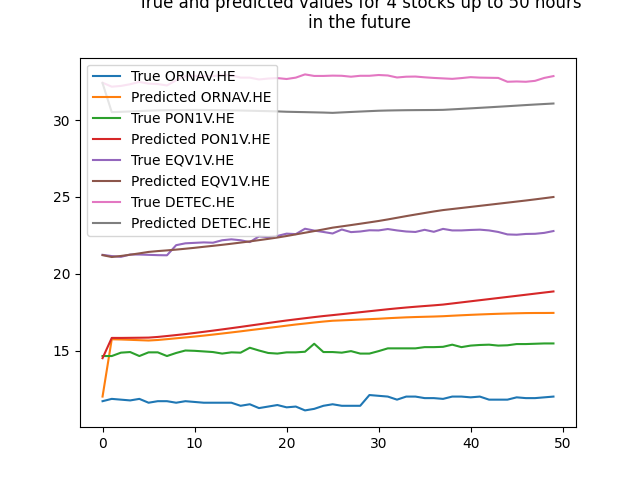

In [ ]:
RECURSE_TO = 50
# Start from the RECURSE_TO latest hour, predict the next hour, and then
# use the predicted hour to predict the next hour, and so on
X_start = X_test[-RECURSE_TO,:,:]
print(f"X_start shape: {X_start.shape}")
Y_preds_recurse = X_start[-1,:].reshape(1,X.shape[2])
Y_true_recurse = Y_test[-RECURSE_TO:,:]
print(f"Y_preds_recurse shape: {Y_preds_recurse.shape}")
print(f"Y_true_recurse shape: {Y_true_recurse.shape}")

for i in range(RECURSE_TO - 1):
    Y_pred_ = model.predict(X_start.reshape(1,MHOURS,X.shape[2]), verbose=0)
    Y_preds_recurse = np.concatenate([Y_preds_recurse, Y_pred_], axis=0)
    # Shift X_start one hour forward
    X_start = np.concatenate([X_start[1:,:], Y_pred_], axis=0)
Y_preds_recurse = np.array(Y_preds_recurse).squeeze()
print(f"Y_preds_recurse shape: {Y_preds_recurse.shape}")

# Invert scaling of predictions
Y_preds_recurse = inverse_transform(Y_preds_recurse)
Y_true_recurse = inverse_transform(Y_true_recurse)

# Select 5 stocks with the smallest mae to plot
mae_recursive_preds = np.mean(np.abs(Y_preds_recurse - Y_true_recurse),
                                axis=0)
stock_idxs = np.argsort(mae_recursive_preds)[:10]
stock_idxs = np.random.choice(stock_idxs, 4, replace=False)

fig, ax = plt.subplots()
for stock_idx in stock_idxs:
    ax.plot(Y_true_recurse[:,stock_idx],
            label=f"True {IND_CONVERSION[stock_idx]}")
    ax.plot(Y_preds_recurse[:,stock_idx],
            label=f"Predicted {IND_CONVERSION[stock_idx]}")
ax.legend()
ax.set_title(f"""
            True and predicted values for 4 stocks up to {RECURSE_TO} hours
            in the future
            """)
plt.savefig("./figures/recursive_prediction.png")

# Calculate the error of the predictions
mae_hourly_preds = np.mean(np.abs(Y_pred - Y_test), axis=0)
print(f"Mean absolute error of hourly predictions: {mae_hourly_preds}")
print(f"""Mean absolute error of recursive predictions:
        {mae_recursive_preds}""")

# As a baseline, calculate how much the price changes per hour on the test
# data
average_hourly_change = np.mean(np.abs(np.diff(Y_test, axis=0)), axis=0)
print(f"Average hourly change: {average_hourly_change}")